# RTC System Data
## Import Libraries

In [1]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & TZ

In [3]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [4]:
# Get Weather Data from URL - June 22
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-06-22/end/2020-06-23/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,24.799999,-7.796340,0.162379,-6.804043,0.0,16.280001,1592784060000,88.500000,2.013
1,24.690001,-6.996712,0.206722,-6.769936,0.0,16.580000,1592784120000,89.900002,2.006
2,24.580000,-6.156893,0.135069,-6.855769,0.0,16.879999,1592784180000,90.000000,1.840
3,24.420000,-8.161592,-0.007655,-6.693103,0.0,17.280001,1592784240000,86.800003,1.854
4,24.370001,-7.870697,0.138671,-6.792580,0.0,17.930000,1592784300000,87.000000,1.839


In [5]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,24.799999,-7.796340,0.162379,-6.804043,1592784060000
1,24.690001,-6.996712,0.206722,-6.769936,1592784120000
2,24.580000,-6.156893,0.135069,-6.855769,1592784180000
3,24.420000,-8.161592,-0.007655,-6.693103,1592784240000
4,24.370001,-7.870697,0.138671,-6.792580,1592784300000


In [6]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [7]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,24.799999,-7.796340,0.162379,-6.804043,1592784060000
1,24.690001,-6.996712,0.206722,-6.769936,1592784120000
2,24.580000,-6.156893,0.135069,-6.855769,1592784180000
3,24.420000,-8.161592,-0.007655,-6.693103,1592784240000
4,24.370001,-7.870697,0.138671,-6.792580,1592784300000


In [8]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [9]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,24.799999,-7.796340,0.162379,-6.804043,2020-06-22 00:01:00
1,24.690001,-6.996712,0.206722,-6.769936,2020-06-22 00:02:00
2,24.580000,-6.156893,0.135069,-6.855769,2020-06-22 00:03:00
3,24.420000,-8.161592,-0.007655,-6.693103,2020-06-22 00:04:00
4,24.370001,-7.870697,0.138671,-6.792580,2020-06-22 00:05:00


In [10]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-06-22 00:01:00,24.799999,-7.796340,0.162379,-6.804043
2020-06-22 00:02:00,24.690001,-6.996712,0.206722,-6.769936
2020-06-22 00:03:00,24.580000,-6.156893,0.135069,-6.855769
2020-06-22 00:04:00,24.420000,-8.161592,-0.007655,-6.693103
2020-06-22 00:05:00,24.370001,-7.870697,0.138671,-6.792580


In [11]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [12]:
# Analyzing Data - June 22
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,1439.000000,1439.000000,1439.000000,1439.000000
mean,30.571098,56.008715,388.992813,342.316458
std,4.927183,60.201369,402.024498,398.336987
min,22.120001,-11.367140,-0.823393,-7.487659
25%,25.030001,-6.789346,0.125758,-6.418729
50%,31.020000,58.402100,238.984207,145.416245
75%,35.599998,106.023540,858.929871,767.736786
max,37.700001,204.562485,960.235474,1040.641968


In [13]:
weather_df_slice = weather_df.iloc[::5] 

## System

In [14]:
# Get System Data from URL - June 22
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-06-22/end/2020-06-23/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,23.416666,-2.317497,0.0,0.0,-0.045,2.2,-2.864445,0.006,1.633333,0.0,1592784060000
1,23.166666,-2.317497,0.0,0.0,-0.045,2.2,-2.496650,0.006,1.650000,0.0,1592784120000
2,23.150000,-2.317497,0.0,0.0,-0.045,2.2,-2.863820,0.006,1.600000,0.0,1592784180000
3,23.208334,-2.317497,0.0,0.0,-0.045,2.2,-2.570096,0.006,1.600000,0.0,1592784240000
4,23.241667,-2.317497,0.0,0.0,-0.045,2.2,-2.349358,0.006,1.600000,0.0,1592784300000


In [15]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [16]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [17]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,23.416666,-2.317497,0.0,0.0,-0.045,2.2,-2.864445,0.006,1.633333,0.0,1592784060000
1,23.166666,-2.317497,0.0,0.0,-0.045,2.2,-2.496650,0.006,1.650000,0.0,1592784120000
2,23.150000,-2.317497,0.0,0.0,-0.045,2.2,-2.863820,0.006,1.600000,0.0,1592784180000
3,23.208334,-2.317497,0.0,0.0,-0.045,2.2,-2.570096,0.006,1.600000,0.0,1592784240000
4,23.241667,-2.317497,0.0,0.0,-0.045,2.2,-2.349358,0.006,1.600000,0.0,1592784300000


In [18]:
system_df.tail()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
1434,24.533333,-1.931247,0.0,0.0,-0.042,2.400000,-2.423955,0.006,1.583333,0.0,1592870100000
1435,24.533333,-2.317497,0.0,0.0,-0.042,2.400000,-2.571052,0.006,1.600000,0.0,1592870160000
1436,24.508331,-2.317497,0.0,0.0,-0.042,2.400000,-2.571229,0.006,1.600000,0.0,1592870220000
1437,24.574999,-2.317497,0.0,0.0,-0.042,2.433333,-2.497685,0.006,1.750000,0.0,1592870280000
1438,24.591665,-2.124372,0.0,0.0,-0.042,2.416667,-2.497840,0.006,1.733333,0.0,1592870340000


In [19]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [20]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,23.416666,-2.317497,0.0,0.0,-0.045,2.2,-2.864445,0.006,1.633333,0.0,2020-06-22 00:01:00
1,23.166666,-2.317497,0.0,0.0,-0.045,2.2,-2.496650,0.006,1.650000,0.0,2020-06-22 00:02:00
2,23.150000,-2.317497,0.0,0.0,-0.045,2.2,-2.863820,0.006,1.600000,0.0,2020-06-22 00:03:00
3,23.208334,-2.317497,0.0,0.0,-0.045,2.2,-2.570096,0.006,1.600000,0.0,2020-06-22 00:04:00
4,23.241667,-2.317497,0.0,0.0,-0.045,2.2,-2.349358,0.006,1.600000,0.0,2020-06-22 00:05:00


In [21]:
system_df.drop(system_df.index[range(0, 340)], axis=0, inplace=True)

In [22]:
system_df.drop(system_df.index[range(1019, 1099)], axis=0, inplace=True)

In [23]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-22 05:41:00,24.583334,24.526842,24.530525,24.027863,-0.02400,387.983307,-2.863813,0.18700,341.733307,42.289463
2020-06-22 05:42:00,24.599998,25.202780,24.712494,24.217741,0.08425,355.250000,19.165682,0.19100,339.183319,43.316067
2020-06-22 05:43:00,24.591665,25.492468,24.727150,24.231794,0.14525,332.149994,34.950699,0.19450,335.666656,43.755432
2020-06-22 05:44:00,24.633333,25.492468,24.802748,24.290113,0.14900,328.800018,35.323200,0.19350,337.966644,44.425457
2020-06-22 05:45:00,24.574999,25.492468,25.167311,24.626923,0.15600,323.850006,37.010830,0.19875,337.000000,45.082245


In [24]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,32.127109,423.900290,412.633057,407.547602,3.358869,268.315093,1014.513107,3.382900,268.574627,1045.809944
std,3.609828,380.117002,377.271442,374.931799,3.090876,122.562831,908.572031,3.067318,128.533750,927.596800
min,23.408333,-5.214368,0.000000,0.000000,-0.042000,2.350000,-2.863813,0.006000,1.400000,0.000000
25%,29.408333,40.556198,42.770979,41.251865,0.302000,304.958313,77.661644,0.327500,306.208313,84.970051
50%,32.908333,331.112396,301.533691,293.537415,2.431250,316.016663,788.355469,2.460000,322.299988,817.754211
75%,35.420834,825.028931,813.303467,807.158783,6.669000,336.066650,2001.900330,6.648125,341.433319,2043.457397
max,37.333332,994.109619,984.315491,973.969971,8.047500,394.916656,2326.561035,8.003500,369.333344,2398.120605


In [25]:
system_df_slice = system_df.iloc[::5] 

In [26]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-22 05:41:00,24.583334,24.526842,24.530525,24.027863,-0.02400,387.983307,-2.863813,0.18700,341.733307,42.289463
2020-06-22 05:46:00,24.558332,26.554651,25.729898,25.140068,0.16425,319.516663,38.839283,0.19900,341.199982,46.028568
2020-06-22 05:51:00,24.666666,32.251831,28.433563,27.674612,0.19250,312.583344,46.329559,0.22300,342.750000,54.910339
2020-06-22 05:56:00,24.724998,39.590572,32.462154,31.617060,0.22825,316.216644,58.166534,0.25675,346.216675,64.399315
2020-06-22 06:01:00,24.750000,43.163380,34.543339,33.581326,0.24900,315.199982,64.524452,0.27875,345.549957,74.641235


In [27]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,32.119076,422.027745,411.072092,405.890646,3.345281,268.834963,1010.576238,3.369317,269.110208,1041.740903
std,3.638514,381.240147,378.028326,375.791804,3.097232,122.630170,910.707290,3.072493,128.154330,929.824397
min,23.408333,-4.634994,0.000000,0.000000,-0.042000,2.350000,-2.863813,0.006000,1.400000,0.000000
25%,29.483333,39.542292,42.832619,41.336261,0.303812,305.666656,77.611826,0.329875,306.520836,84.982412
50%,32.820831,330.533005,305.716034,294.927856,2.525625,315.933334,807.268707,2.535750,321.549988,834.441101
75%,35.437501,823.097687,811.867508,806.238205,6.659375,335.100006,1999.338898,6.652437,341.266670,2043.232727
max,37.116665,991.695557,978.510315,972.260071,7.987250,389.583344,2316.865479,7.966500,366.966644,2393.528564


# Weather and System Plot
## Weather June 22

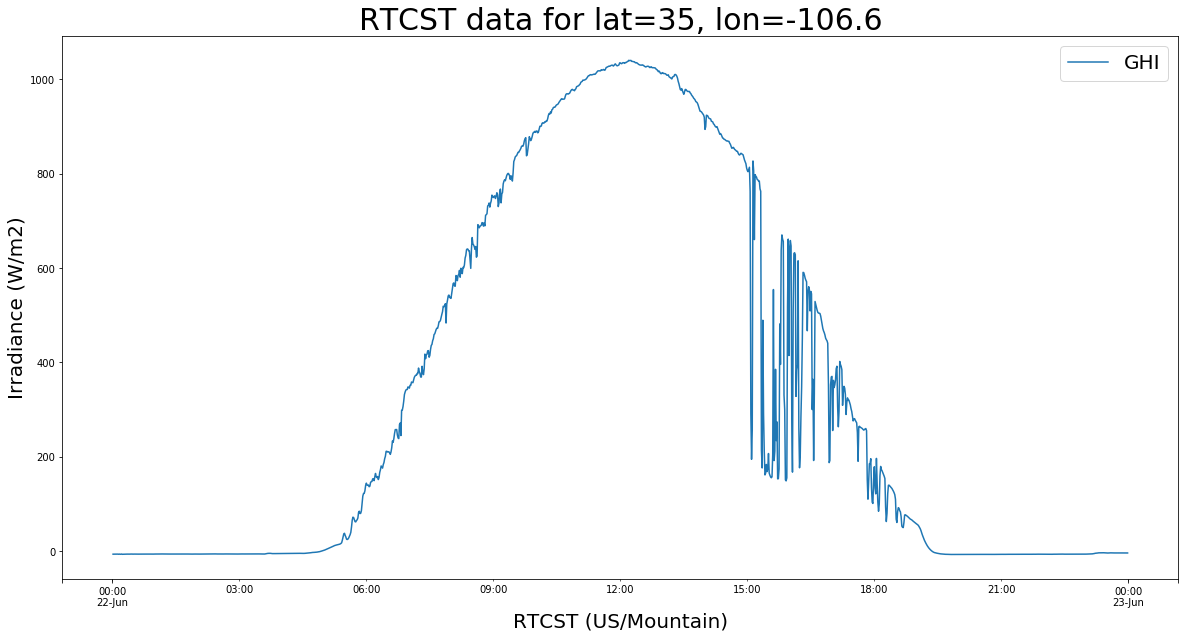

In [28]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

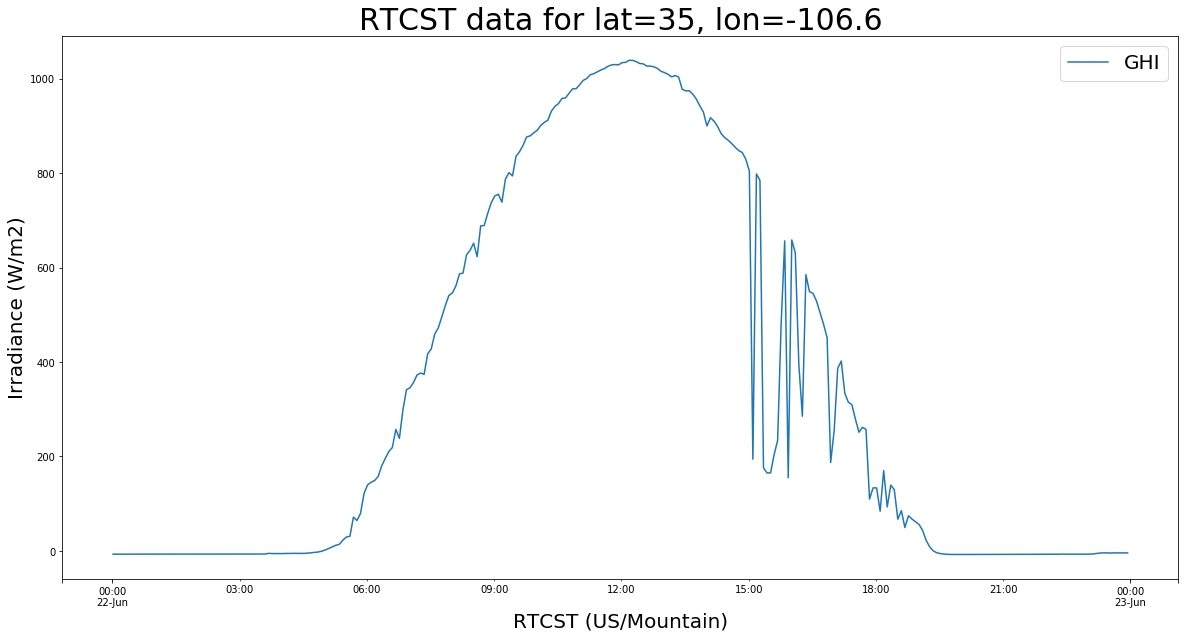

In [29]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV June 22

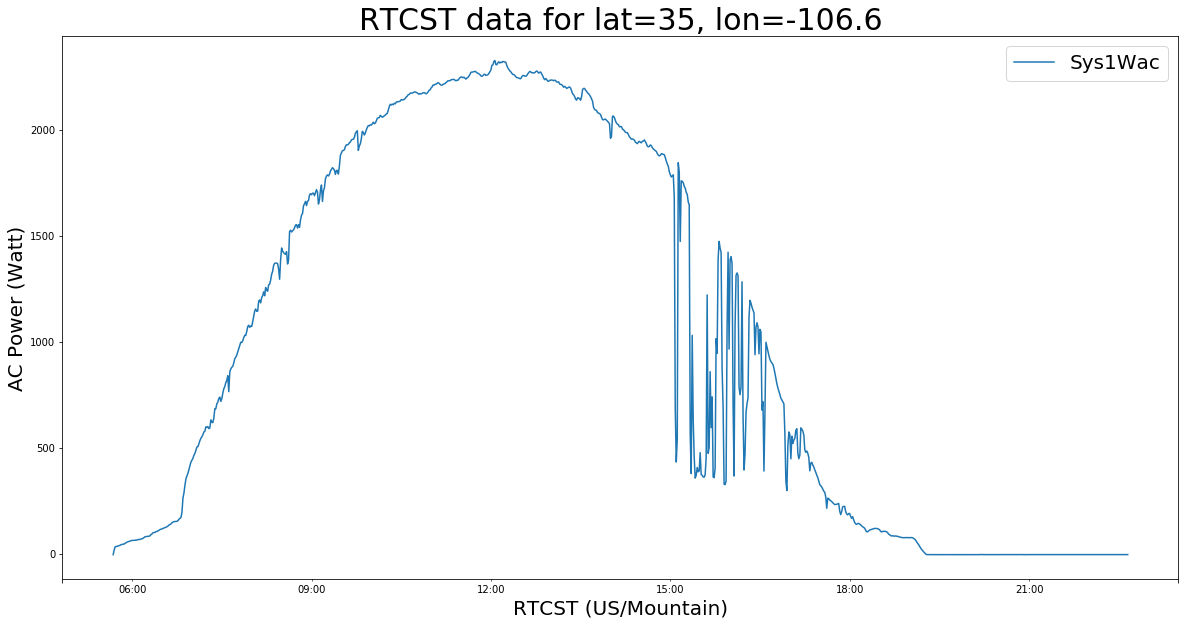

In [30]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

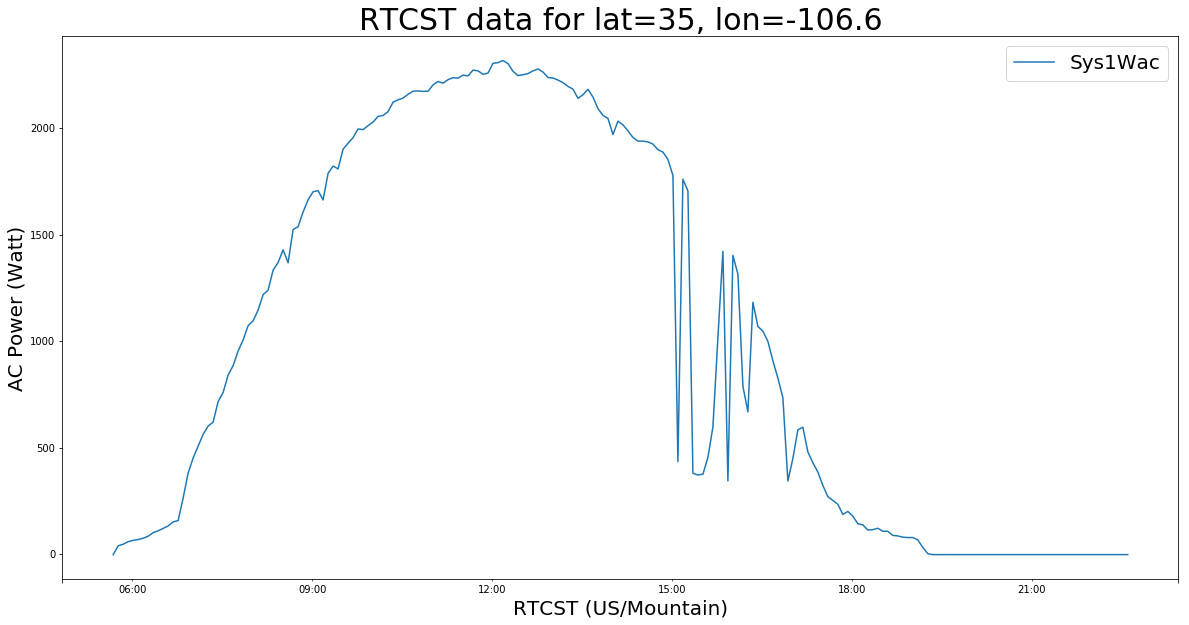

In [31]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

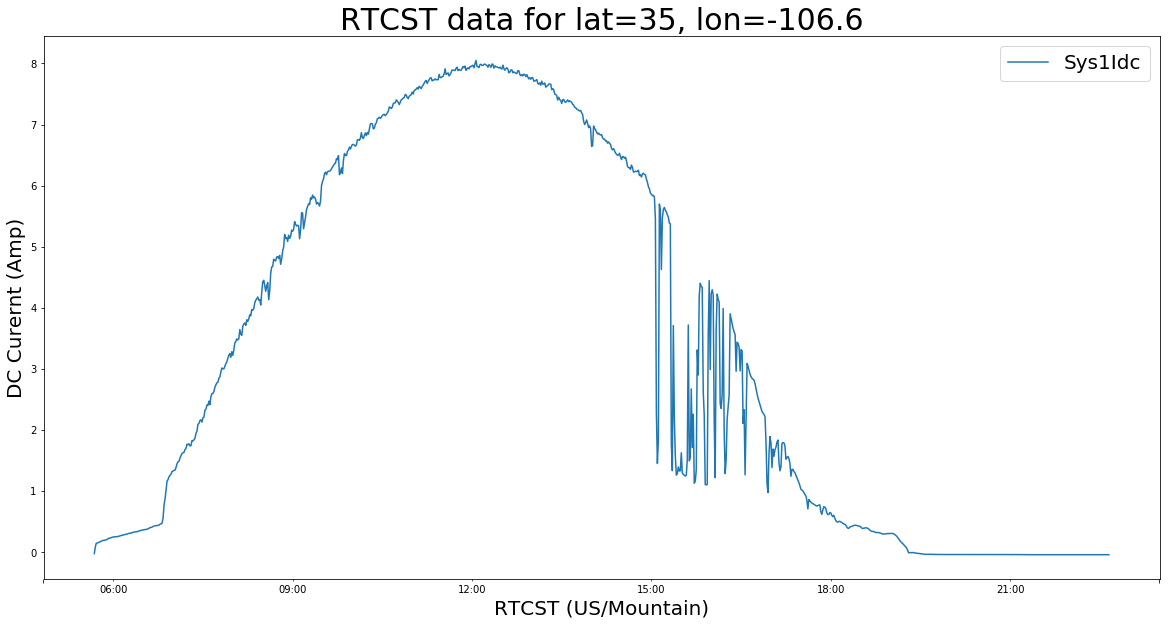

In [32]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

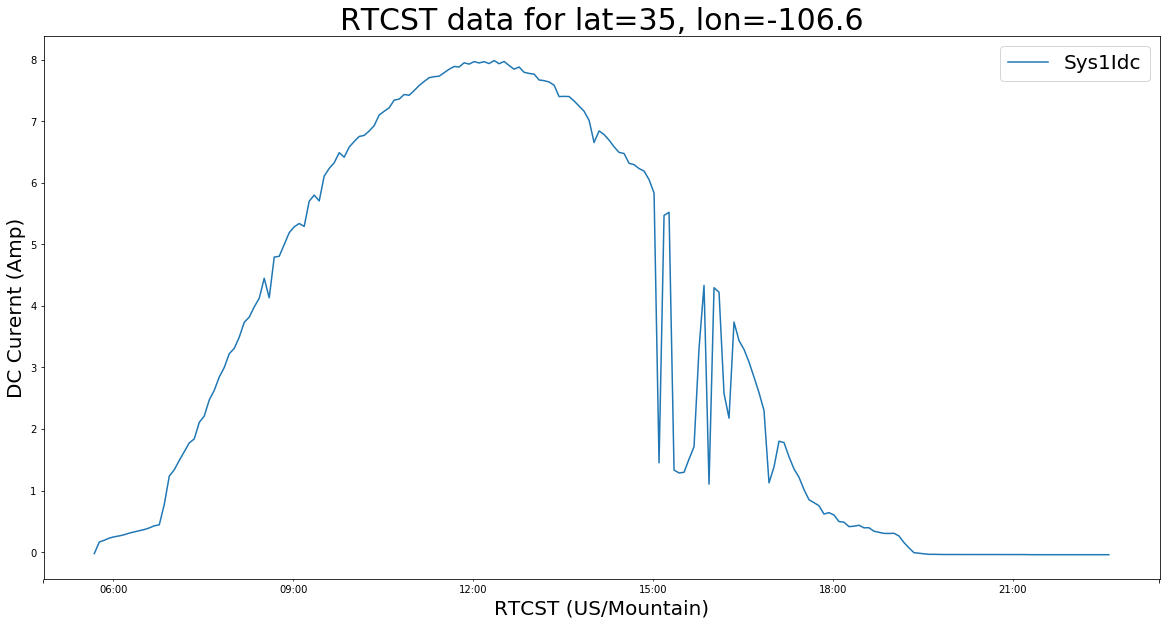

In [33]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

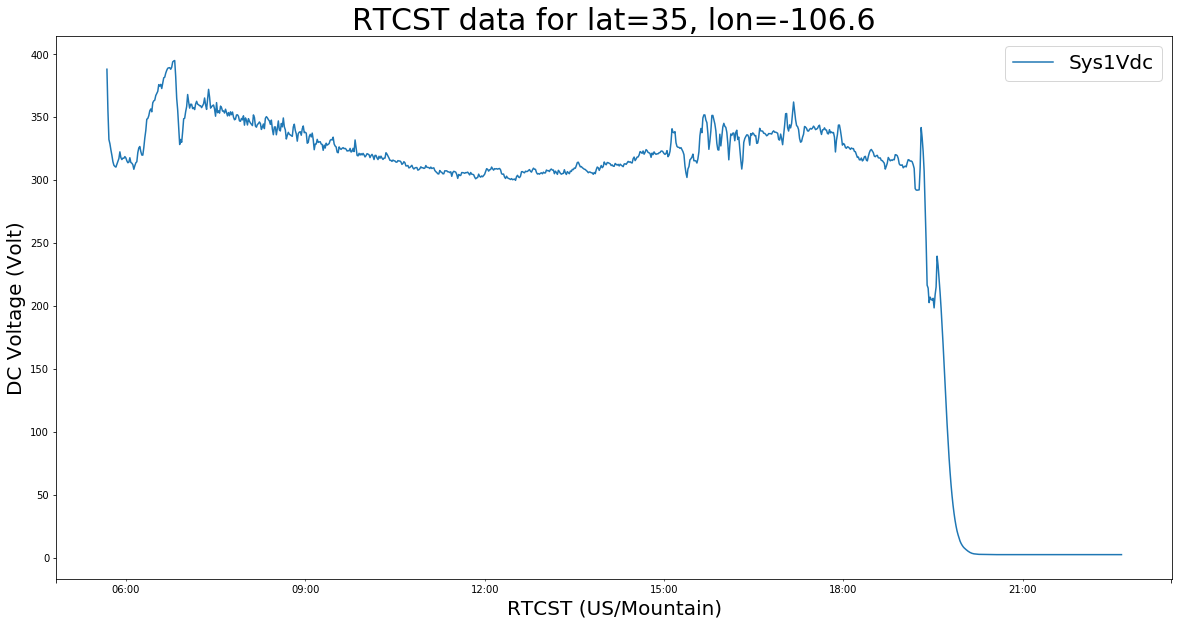

In [34]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

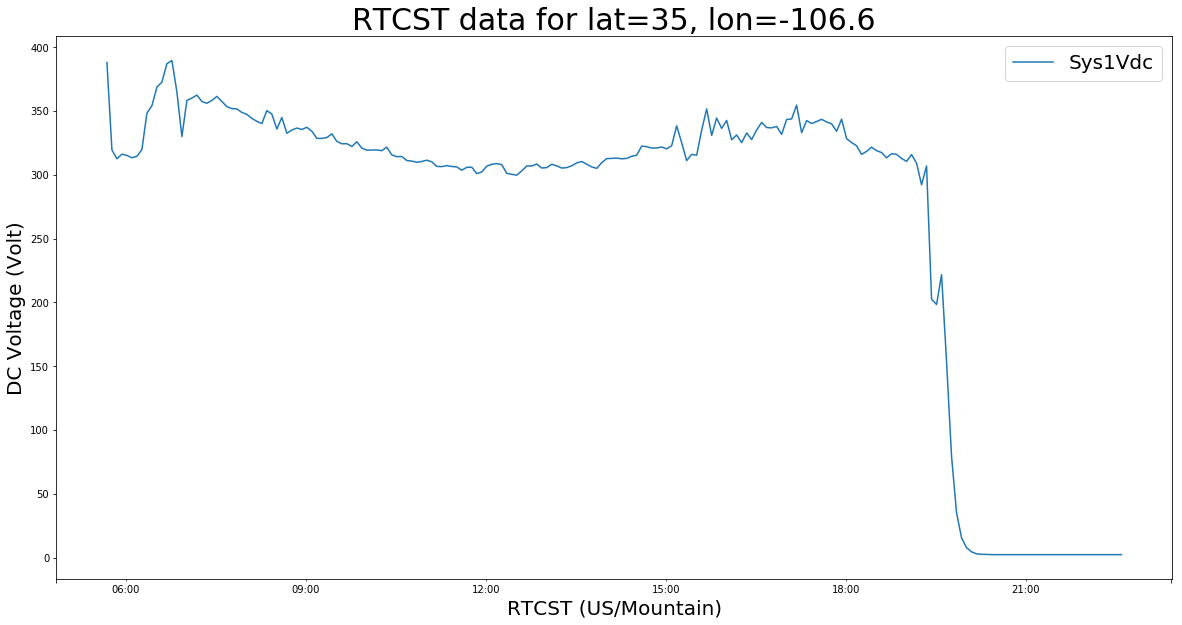

In [35]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## Read HRRR CSV's

In [36]:
# Read HRRR Irradiance CSV
hrrr_df = pd.read_csv('HRRR June 22.csv')
print("Keys of hrrr_df: \n{}".format(hrrr_df.keys()))

Keys of hrrr_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [37]:
hrrr_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,450.315699,456.051963,122.984845
std,381.447894,317.572294,101.119974
min,0.000000,0.000000,0.000000
25%,37.683627,63.531474,24.976151
50%,448.856575,655.749928,109.002695
75%,817.316152,708.670133,208.733027
max,971.439125,725.304593,284.013544


In [38]:
hrrr_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-22 06:00:00-06:00,0.300140,0.000000,0.300140
1,2020-06-22 07:00:00-06:00,115.904089,254.125897,65.074187
2,2020-06-22 08:00:00-06:00,317.857482,559.103685,96.818999
3,2020-06-22 09:00:00-06:00,520.570555,693.949270,118.584024
4,2020-06-22 10:00:00-06:00,700.049123,724.227239,164.646314


In [39]:
# Read Forecast AC Power CSV
ac_df = pd.read_csv('HRRR AC June 22.csv')
print("Keys of ac_df: \n{}".format(ac_df.keys()))

Keys of ac_df: 
Index(['2020-06-22 06:00:00-06:00', '-1.56'], dtype='object')


In [40]:
ac_df.head()

,2020-06-22 06:00:00-06:00,-1.56
0,2020-06-22 06:05:00-06:00,-1.560000
1,2020-06-22 06:10:00-06:00,-1.560000
2,2020-06-22 06:15:00-06:00,-1.560000
3,2020-06-22 06:20:00-06:00,-1.560000
4,2020-06-22 06:25:00-06:00,-10.262546


In [41]:
# TimeStamp as Index
ac_df.set_index('2020-06-22 06:00:00-06:00', inplace=True)
ac_df.head()

,-1.56
2020-06-22 06:00:00-06:00,
2020-06-22 06:05:00-06:00,-1.560000
2020-06-22 06:10:00-06:00,-1.560000
2020-06-22 06:15:00-06:00,-1.560000
2020-06-22 06:20:00-06:00,-1.560000
2020-06-22 06:25:00-06:00,-10.262546


In [42]:
ac_df.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_df.head()

,AC Power
2020-06-22 06:00:00-06:00,
2020-06-22 06:05:00-06:00,-1.560000
2020-06-22 06:10:00-06:00,-1.560000
2020-06-22 06:15:00-06:00,-1.560000
2020-06-22 06:20:00-06:00,-1.560000
2020-06-22 06:25:00-06:00,-10.262546


In [43]:
ac_df.describe()

,AC Power
count,204.000000
mean,1199.843142
std,958.720549
min,-10.262546
25%,81.568468
50%,1276.243306
75%,2185.364837
max,2455.720507


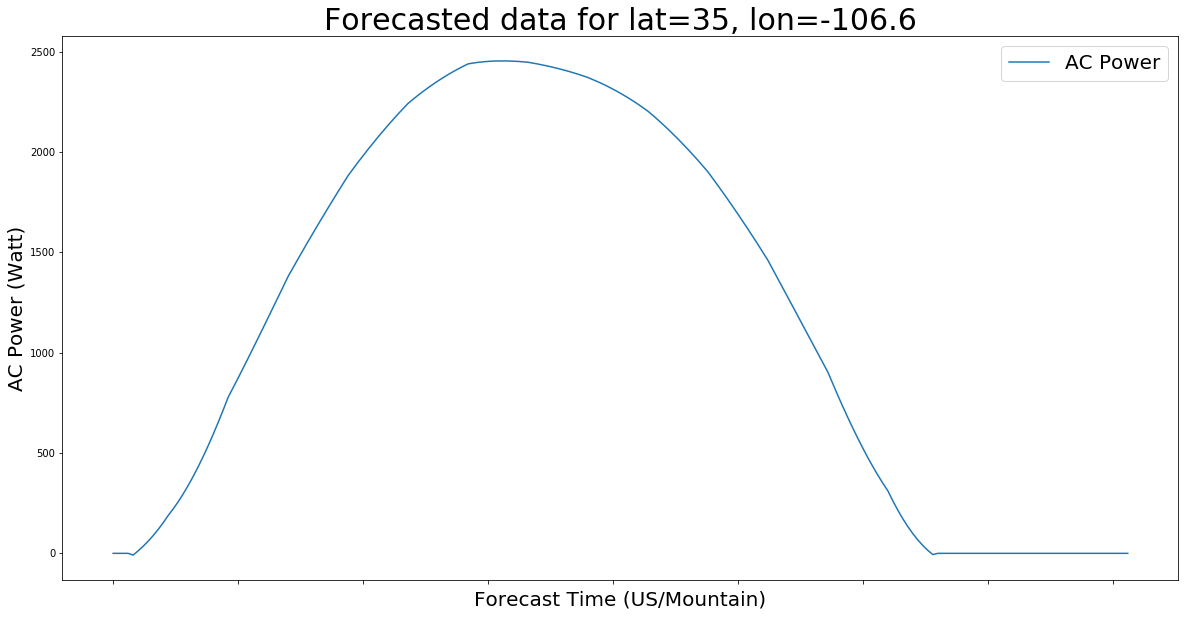

In [44]:
# Plot AC Power
forecast_ac = ['AC Power']
ac_df[forecast_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [45]:
# Read Forecast DC Power CSV
dc_df = pd.read_csv('HRRR DC June 22.csv')
print("Keys of dc_df: \n{}".format(dc_df.keys()))

Keys of dc_df: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [46]:
dc_df.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2.387166,2.129549,600.394493,477.278531,1281.084105,2.331084,1.553217
std,1.868754,1.662003,289.270230,234.761787,999.153840,1.825961,1.185579
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.321339,0.289795,679.998603,526.371296,145.620173,0.313024,0.230513
50%,2.487783,2.227263,741.290533,590.756256,1376.829494,2.427060,1.682446
75%,4.285753,3.821813,759.264831,612.600658,2303.965800,4.186375,2.751884
max,4.903640,4.357555,772.546232,630.377243,2585.671666,4.791930,3.092781


In [47]:
dc_df.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-22 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-22 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-22 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-06-22 06:15:00-06:00,0.058797,0.053199,622.959007,377.271892,20.070597,0.057265,0.042471
4,2020-06-22 06:20:00-06:00,0.111235,0.100630,653.166068,450.991363,45.383177,0.108341,0.080238


### Merge DataFrames

In [48]:
# Clear Index
ac_df=ac_df.reset_index()
system_df_slice=system_df_slice.reset_index()

In [49]:
ac_df.head()

,2020-06-22 06:00:00-06:00,AC Power
0,2020-06-22 06:05:00-06:00,-1.560000
1,2020-06-22 06:10:00-06:00,-1.560000
2,2020-06-22 06:15:00-06:00,-1.560000
3,2020-06-22 06:20:00-06:00,-1.560000
4,2020-06-22 06:25:00-06:00,-10.262546


In [50]:
ac_df.describe()

,AC Power
count,204.000000
mean,1199.843142
std,958.720549
min,-10.262546
25%,81.568468
50%,1276.243306
75%,2185.364837
max,2455.720507


In [51]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-06-22 05:41:00,24.583334,24.526842,24.530525,24.027863,-0.02400,387.983307,-2.863813,0.18700,341.733307,42.289463
1,2020-06-22 05:46:00,24.558332,26.554651,25.729898,25.140068,0.16425,319.516663,38.839283,0.19900,341.199982,46.028568
2,2020-06-22 05:51:00,24.666666,32.251831,28.433563,27.674612,0.19250,312.583344,46.329559,0.22300,342.750000,54.910339
3,2020-06-22 05:56:00,24.724998,39.590572,32.462154,31.617060,0.22825,316.216644,58.166534,0.25675,346.216675,64.399315
4,2020-06-22 06:01:00,24.750000,43.163380,34.543339,33.581326,0.24900,315.199982,64.524452,0.27875,345.549957,74.641235


In [52]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,32.119076,422.027745,411.072092,405.890646,3.345281,268.834963,1010.576238,3.369317,269.110208,1041.740903
std,3.638514,381.240147,378.028326,375.791804,3.097232,122.630170,910.707290,3.072493,128.154330,929.824397
min,23.408333,-4.634994,0.000000,0.000000,-0.042000,2.350000,-2.863813,0.006000,1.400000,0.000000
25%,29.483333,39.542292,42.832619,41.336261,0.303812,305.666656,77.611826,0.329875,306.520836,84.982412
50%,32.820831,330.533005,305.716034,294.927856,2.525625,315.933334,807.268707,2.535750,321.549988,834.441101
75%,35.437501,823.097687,811.867508,806.238205,6.659375,335.100006,1999.338898,6.652437,341.266670,2043.232727
max,37.116665,991.695557,978.510315,972.260071,7.987250,389.583344,2316.865479,7.966500,366.966644,2393.528564


In [53]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_df['System']=system
ac_df.head()

,2020-06-22 06:00:00-06:00,AC Power,System
0,2020-06-22 06:05:00-06:00,-1.560000,-2.863813
1,2020-06-22 06:10:00-06:00,-1.560000,38.839283
2,2020-06-22 06:15:00-06:00,-1.560000,46.329559
3,2020-06-22 06:20:00-06:00,-1.560000,58.166534
4,2020-06-22 06:25:00-06:00,-10.262546,64.524452


In [54]:
# TimeStamp as Index
ac_df.set_index('2020-06-22 06:00:00-06:00', inplace=True)
ac_df.head()

,AC Power,System
2020-06-22 06:00:00-06:00,,
2020-06-22 06:05:00-06:00,-1.560000,-2.863813
2020-06-22 06:10:00-06:00,-1.560000,38.839283
2020-06-22 06:15:00-06:00,-1.560000,46.329559
2020-06-22 06:20:00-06:00,-1.560000,58.166534
2020-06-22 06:25:00-06:00,-10.262546,64.524452


In [55]:
# Examine the column labels
all(isinstance(column, str) for column in ac_df.columns)

True

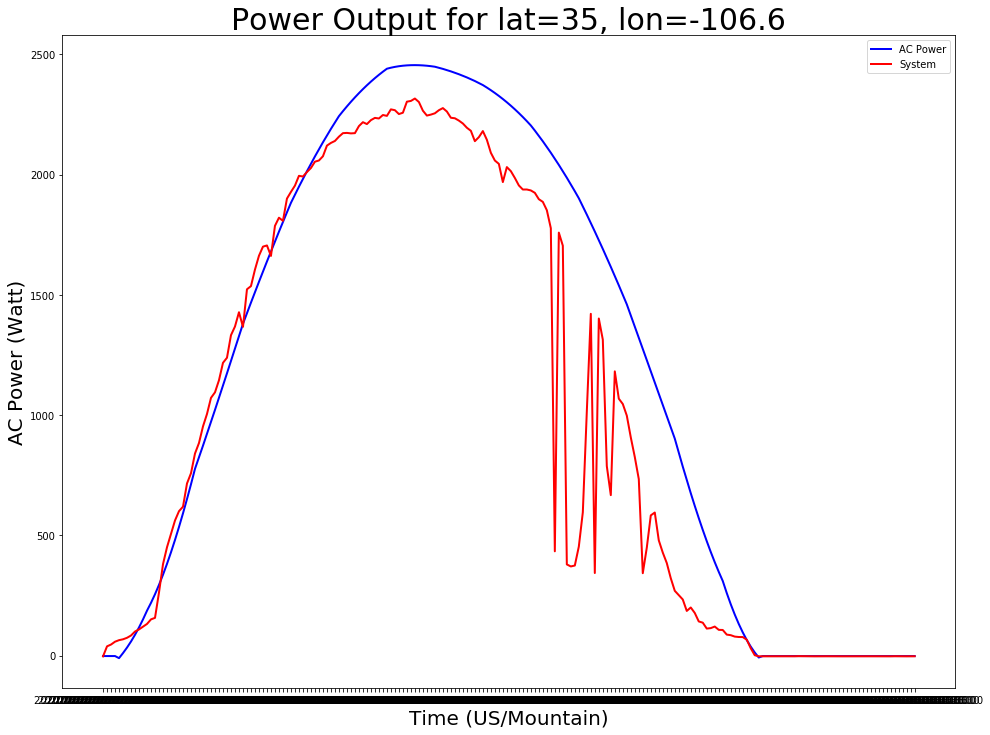

In [56]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_df, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_df, marker='', color='red', linewidth=2);
plt.legend();

## Read NDFD CSV's

In [57]:
# Read NDFD Irradiance CSV
ndfd_df = pd.read_csv('NDFD June 22.csv')
print("Keys of ndfd_df: \n{}".format(ndfd_df.keys()))

Keys of ndfd_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [58]:
ndfd_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,450.315699,456.051963,122.984845
std,381.447894,317.572294,101.119974
min,0.000000,0.000000,0.000000
25%,37.683627,63.531474,24.976151
50%,448.856575,655.749928,109.002695
75%,817.316152,708.670133,208.733027
max,971.439125,725.304593,284.013544


In [59]:
ndfd_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-22 06:00:00-06:00,0.300140,0.000000,0.300140
1,2020-06-22 07:00:00-06:00,115.904089,254.125897,65.074187
2,2020-06-22 08:00:00-06:00,317.857482,559.103685,96.818999
3,2020-06-22 09:00:00-06:00,520.570555,693.949270,118.584024
4,2020-06-22 10:00:00-06:00,700.049123,724.227239,164.646314


In [60]:
# Read Forecast AC Power CSV
ac_ndfd = pd.read_csv('NDFD AC June 22.csv')
print("Keys of ac_ndfd: \n{}".format(ac_ndfd.keys()))

Keys of ac_ndfd: 
Index(['2020-06-22 06:00:00-06:00', '-1.56'], dtype='object')


In [61]:
ac_ndfd.head()

,2020-06-22 06:00:00-06:00,-1.56
0,2020-06-22 06:05:00-06:00,-1.560000
1,2020-06-22 06:10:00-06:00,-1.560000
2,2020-06-22 06:15:00-06:00,-1.560000
3,2020-06-22 06:20:00-06:00,-1.560000
4,2020-06-22 06:25:00-06:00,-9.262681


In [62]:
# TimeStamp as Index
ac_ndfd.set_index('2020-06-22 06:00:00-06:00', inplace=True)
ac_ndfd.head()

,-1.56
2020-06-22 06:00:00-06:00,
2020-06-22 06:05:00-06:00,-1.560000
2020-06-22 06:10:00-06:00,-1.560000
2020-06-22 06:15:00-06:00,-1.560000
2020-06-22 06:20:00-06:00,-1.560000
2020-06-22 06:25:00-06:00,-9.262681


In [63]:
ac_ndfd.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_ndfd.head()

,AC Power
2020-06-22 06:00:00-06:00,
2020-06-22 06:05:00-06:00,-1.560000
2020-06-22 06:10:00-06:00,-1.560000
2020-06-22 06:15:00-06:00,-1.560000
2020-06-22 06:20:00-06:00,-1.560000
2020-06-22 06:25:00-06:00,-9.262681


In [64]:
ac_ndfd.describe()

,AC Power
count,216.000000
mean,961.019262
std,827.825000
min,-9.262681
25%,-1.560000
50%,953.584118
75%,1778.262090
max,2162.006689


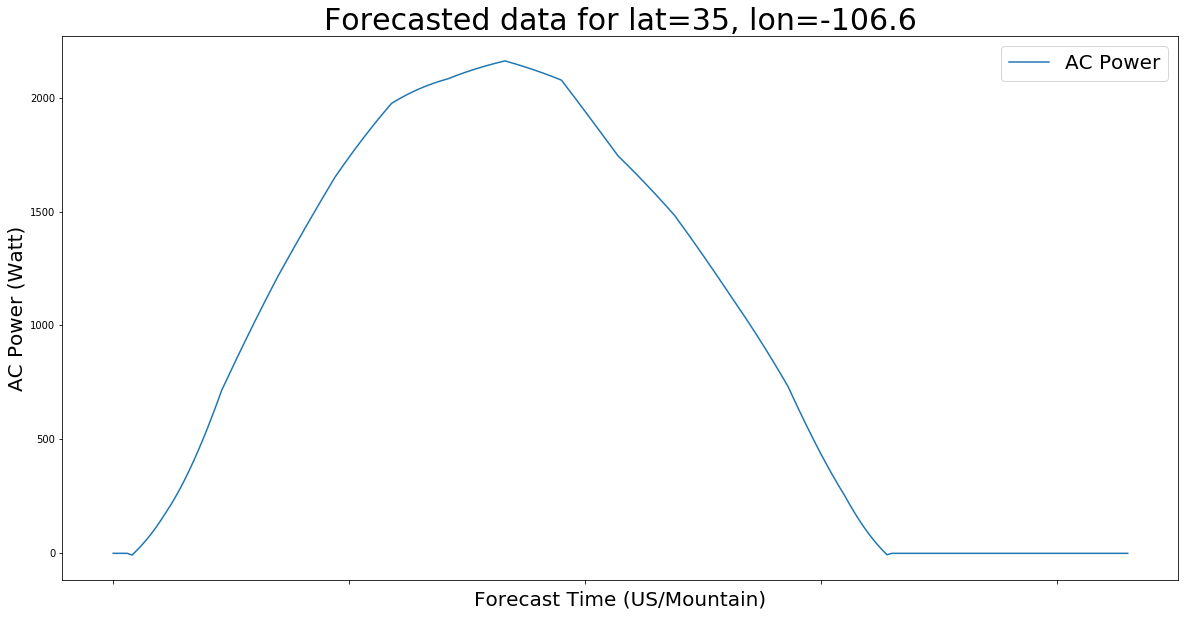

In [65]:
# Plot AC Power
ndfd_ac = ['AC Power']
ac_ndfd[ndfd_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [66]:
# Read Forecast DC Power CSV
dc_ndfd = pd.read_csv('NDFD DC June 22.csv')
print("Keys of dc_ndfd: \n{}".format(dc_ndfd.keys()))

Keys of dc_ndfd: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [67]:
dc_ndfd.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,1.916223,1.712799,563.502218,449.243031,1034.879189,1.870422,1.268694
std,1.594101,1.421653,311.196625,253.086662,867.184814,1.556772,1.034255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.114499,0.103538,617.016880,401.538996,45.869266,0.111520,0.082586
50%,1.912896,1.719050,733.710076,593.428314,1032.299159,1.865471,1.314215
75%,3.488124,3.112884,759.152220,610.794758,1883.689906,3.405336,2.293083
max,4.193227,3.738175,763.863831,625.657361,2284.921026,4.095720,2.700173


In [68]:
dc_ndfd.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-22 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-22 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-22 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-06-22 06:15:00-06:00,0.060888,0.055067,617.016880,371.106224,20.435783,0.059302,0.043980
4,2020-06-22 06:20:00-06:00,0.114499,0.103538,647.386339,444.893134,46.063377,0.111520,0.082586


### Merge DataFrames

In [69]:
# Clear Index
ac_ndfd=ac_ndfd.reset_index()

In [70]:
ac_ndfd.head()

,2020-06-22 06:00:00-06:00,AC Power
0,2020-06-22 06:05:00-06:00,-1.560000
1,2020-06-22 06:10:00-06:00,-1.560000
2,2020-06-22 06:15:00-06:00,-1.560000
3,2020-06-22 06:20:00-06:00,-1.560000
4,2020-06-22 06:25:00-06:00,-9.262681


In [71]:
ac_ndfd.describe()

,AC Power
count,216.000000
mean,961.019262
std,827.825000
min,-9.262681
25%,-1.560000
50%,953.584118
75%,1778.262090
max,2162.006689


In [72]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_ndfd['System']=system
ac_ndfd.head()

,2020-06-22 06:00:00-06:00,AC Power,System
0,2020-06-22 06:05:00-06:00,-1.560000,-2.863813
1,2020-06-22 06:10:00-06:00,-1.560000,38.839283
2,2020-06-22 06:15:00-06:00,-1.560000,46.329559
3,2020-06-22 06:20:00-06:00,-1.560000,58.166534
4,2020-06-22 06:25:00-06:00,-9.262681,64.524452


In [73]:
# TimeStamp as Index
ac_ndfd.set_index('2020-06-22 06:00:00-06:00', inplace=True)
ac_ndfd.head()

,AC Power,System
2020-06-22 06:00:00-06:00,,
2020-06-22 06:05:00-06:00,-1.560000,-2.863813
2020-06-22 06:10:00-06:00,-1.560000,38.839283
2020-06-22 06:15:00-06:00,-1.560000,46.329559
2020-06-22 06:20:00-06:00,-1.560000,58.166534
2020-06-22 06:25:00-06:00,-9.262681,64.524452


In [74]:
# Examine the column labels
all(isinstance(column, str) for column in ac_ndfd.columns)

True

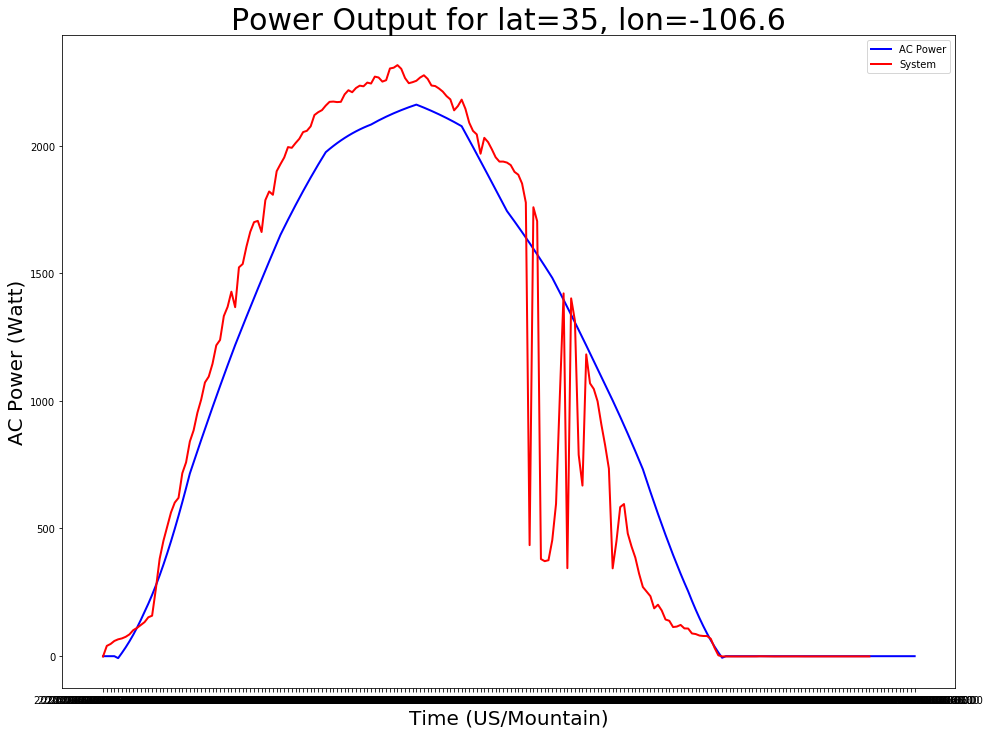

In [75]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_ndfd, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_ndfd, marker='', color='red', linewidth=2);
plt.legend();

## Error
### Mean Square Error

In [76]:
y_true= system_df_slice['Sys1Wac']
y_pred= ac_df['AC Power']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))

Mean Square Error:
 144327.08821995388
